In [ ]:
!git clone 'https://github.com/Shenggan/BCCD_Dataset.git'

Cloning into 'BCCD_Dataset'...
remote: Enumerating objects: 800, done.
remote: Total 800 (delta 0), reused 0 (delta 0), pack-reused 800
Receiving objects: 100% (800/800), 7.39 MiB | 2.56 MiB/s, done.
Resolving deltas: 100% (378/378), done.


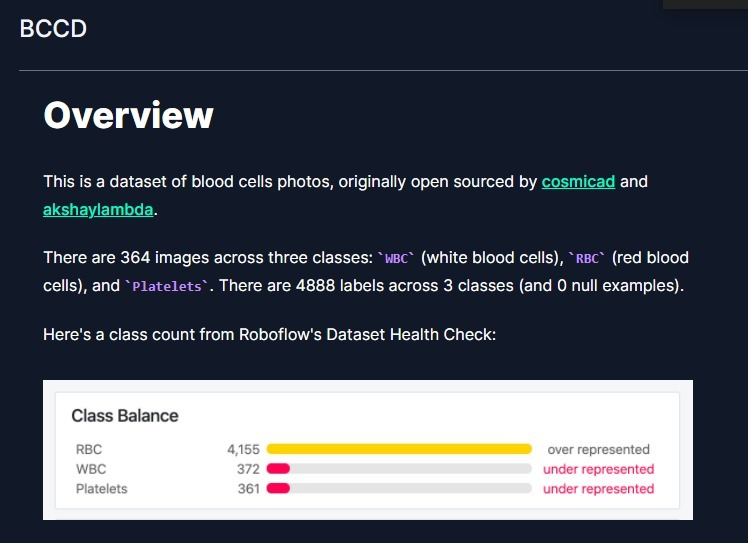

#**DATA PRE-PROCESSING STARTS**

# Extraction of data labels from .xml file to dataframe

In [ ]:
import shutil
import os, sys, random
import xml.etree.ElementTree as ET
from glob import glob
import pandas as pd
from shutil import copyfile
import pandas as pd
from sklearn import preprocessing, model_selection
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import patches
import numpy as np
import os

# Train Data Frame


In [ ]:
annotations = sorted(glob('/content/BCCD_Dataset/BCCD/Annotations/*.xml'))

desiredFiles = []
with open('/content/BCCD_Dataset/BCCD/ImageSets/Main/train.txt','r') as f:
    lines=f.readlines()
    for line in lines:
        desiredFiles.append(line.strip())

df = []
cnt = 0
# i=0
for file in annotations:
  prev_filename = file.split('/')[-1].split('.')[0] + '.jpg'
  filename = str(cnt) + '.jpg'
  f1 = file.split('\\')[-1].split('.')[0].split('/')[5]
  row = []
  parsedXML = ET.parse(file)
#   print(f1)
#   if i==2:
#       break
#   i+=1
  if f1 in desiredFiles:
    for node in parsedXML.getroot().iter('object'):
        blood_cells = node.find('name').text
        xmin = int(node.find('bndbox/xmin').text)
        xmax = int(node.find('bndbox/xmax').text)
        ymin = int(node.find('bndbox/ymin').text)
        ymax = int(node.find('bndbox/ymax').text)

        row = [prev_filename, filename, blood_cells, xmin, xmax, ymin, ymax]
        df.append(row)
    cnt += 1

print(cnt)
df_train = pd.DataFrame(df, columns=['prev_filename', 'filename', 'cell_type', 'xmin', 'xmax', 'ymin', 'ymax'])

df_train[['prev_filename','filename', 'cell_type', 'xmin', 'xmax', 'ymin', 'ymax']].to_csv('/content/blood_cell_detection_train.csv', index=False)


205


# Validation Data Frame

In [ ]:
annotations = sorted(glob('/content/BCCD_Dataset/BCCD/Annotations/*.xml'))

desiredFiles = []
with open('/content/BCCD_Dataset/BCCD/ImageSets/Main/val.txt','r') as f:
    lines=f.readlines()
    for line in lines:
        desiredFiles.append(line.strip())

df = []
cnt = 0
# i=0
for file in annotations:
  prev_filename = file.split('/')[-1].split('.')[0] + '.jpg'
  filename = str(cnt) + '.jpg'
  f1 = file.split('\\')[-1].split('.')[0].split('/')[5]
  row = []
  parsedXML = ET.parse(file)
#   print(f1)
#   if i==2:
#       break
#   i+=1
  if f1 in desiredFiles:
    for node in parsedXML.getroot().iter('object'):
        blood_cells = node.find('name').text
        xmin = int(node.find('bndbox/xmin').text)
        xmax = int(node.find('bndbox/xmax').text)
        ymin = int(node.find('bndbox/ymin').text)
        ymax = int(node.find('bndbox/ymax').text)

        row = [prev_filename, filename, blood_cells, xmin, xmax, ymin, ymax]
        df.append(row)
    cnt += 1

print(cnt)
df_val = pd.DataFrame(df, columns=['prev_filename', 'filename', 'cell_type', 'xmin', 'xmax', 'ymin', 'ymax'])

df_val[['prev_filename','filename', 'cell_type', 'xmin', 'xmax', 'ymin', 'ymax']].to_csv('/content/blood_cell_detection_val.csv', index=False)


87


# Test Data Frame

In [ ]:
annotations = sorted(glob('/content/BCCD_Dataset/BCCD/Annotations/*.xml'))

desiredFiles = []
with open('/content/BCCD_Dataset/BCCD/ImageSets/Main/test.txt','r') as f:
    lines=f.readlines()
    for line in lines:
        desiredFiles.append(line.strip())

df = []
cnt = 0
# i=0
for file in annotations:
  prev_filename = file.split('/')[-1].split('.')[0] + '.jpg'
  filename = str(cnt) + '.jpg'
  f1 = file.split('\\')[-1].split('.')[0].split('/')[5]
  row = []
  parsedXML = ET.parse(file)
#   print(f1)
#   if i==2:
#       break
#   i+=1
  if f1 in desiredFiles:
    for node in parsedXML.getroot().iter('object'):
        blood_cells = node.find('name').text
        xmin = int(node.find('bndbox/xmin').text)
        xmax = int(node.find('bndbox/xmax').text)
        ymin = int(node.find('bndbox/ymin').text)
        ymax = int(node.find('bndbox/ymax').text)

        row = [prev_filename, filename, blood_cells, xmin, xmax, ymin, ymax]
        df.append(row)
    cnt += 1

print(cnt)
df_test = pd.DataFrame(df, columns=['prev_filename', 'filename', 'cell_type', 'xmin', 'xmax', 'ymin', 'ymax'])

df_test[['prev_filename','filename', 'cell_type', 'xmin', 'xmax', 'ymin', 'ymax']].to_csv('/content/blood_cell_detection_test.csv', index=False)

72


# Processing data as per the YOLO_V5 format

**DATAFRAME STRUCTURE**

- filename : contains the name of the image
- cell_type: denotes the type of the cell
- xmin: x-coordinate of the bottom left part of the image
- xmax: x-coordinate of the top right part of the image
- ymin: y-coordinate of the bottom left part of the image
- ymax: y-coordinate of the top right part of the image
- labels : Encoded cell-type **(Yolo - label input-1)**
- width : width of that bbox
- height : height of that bbox
- x_center : bbox center (x-axis)
-	y_center : bbox center (y-axis)
-	x_center_norm	: x_center normalized (0-1) **(Yolo - label input-2)**
-	y_center_norm : y_center normalized (0-1) **(Yolo - label input-3)**
- width_norm : width normalized (0-1) **(Yolo - label input-4)**
-	height_norm : height normalized (0-1) **(Yolo - label input-5)**

## Train preprocessing

In [ ]:
img_width = 640
img_height = 480

def width(df):
  return int(df.xmax - df.xmin)
def height(df):
  return int(df.ymax - df.ymin)
def x_center(df):
  return int(df.xmin + (df.width/2))
def y_center(df):
  return int(df.ymin + (df.height/2))
def w_norm(df):
  return df/img_width
def h_norm(df):
  return df/img_height

df_train = pd.read_csv('/content/blood_cell_detection_train.csv')

le = preprocessing.LabelEncoder()
le.fit(df_train['cell_type'])
print(le.classes_)
labels = le.transform(df_train['cell_type'])
df_train['labels'] = labels

df_train['width'] = df_train.apply(width, axis=1)
df_train['height'] = df_train.apply(height, axis=1)

df_train['x_center'] = df_train.apply(x_center, axis=1)
df_train['y_center'] = df_train.apply(y_center, axis=1)

df_train['x_center_norm'] = df_train['x_center'].apply(w_norm)
df_train['width_norm'] = df_train['width'].apply(w_norm)

df_train['y_center_norm'] = df_train['y_center'].apply(h_norm)
df_train['height_norm'] = df_train['height'].apply(h_norm)

df_train.head(30)

['Platelets' 'RBC' 'WBC']


,prev_filename,filename,cell_type,xmin,xmax,ymin,ymax,labels,width,height,x_center,y_center,x_center_norm,width_norm,y_center_norm,height_norm
0,BloodImage_00001.jpg,0.jpg,WBC,68,286,315,480,2,218,165,177,397,0.276562,0.340625,0.827083,0.343750
1,BloodImage_00001.jpg,0.jpg,RBC,346,446,361,454,1,100,93,396,407,0.618750,0.156250,0.847917,0.193750
2,BloodImage_00001.jpg,0.jpg,RBC,53,146,179,299,1,93,120,99,239,0.154688,0.145313,0.497917,0.250000
3,BloodImage_00001.jpg,0.jpg,RBC,449,536,400,480,1,87,80,492,440,0.768750,0.135937,0.916667,0.166667
4,BloodImage_00001.jpg,0.jpg,RBC,461,548,132,212,1,87,80,504,172,0.787500,0.135937,0.358333,0.166667
5,BloodImage_00001.jpg,0.jpg,RBC,454,541,295,375,1,87,80,497,335,0.776563,0.135937,0.697917,0.166667
6,BloodImage_00001.jpg,0.jpg,RBC,417,508,283,383,1,91,100,462,333,0.721875,0.142187,0.693750,0.208333
7,BloodImage_00001.jpg,0.jpg,RBC,278,369,342,451,1,91,109,323,396,0.504687,0.142187,0.825000,0.227083
8,BloodImage_00001.jpg,0.jpg,RBC,545,636,62,159,1,91,97,590,110,0.921875,0.142187,0.229167,0.202083
9,BloodImage_00001.jpg,0.jpg,RBC,485,576,91,188,1,91,97,530,139,0.828125,0.142187,0.289583,0.202083


## Validation preprocessing

In [ ]:
img_width = 640
img_height = 480

def width(df):
  return int(df.xmax - df.xmin)
def height(df):
  return int(df.ymax - df.ymin)
def x_center(df):
  return int(df.xmin + (df.width/2))
def y_center(df):
  return int(df.ymin + (df.height/2))
def w_norm(df):
  return df/img_width
def h_norm(df):
  return df/img_height

df_val = pd.read_csv('/content/blood_cell_detection_val.csv')

le = preprocessing.LabelEncoder()
le.fit(df_val['cell_type'])
print(le.classes_)
labels = le.transform(df_val['cell_type'])
df_val['labels'] = labels

df_val['width'] = df_val.apply(width, axis=1)
df_val['height'] = df_val.apply(height, axis=1)

df_val['x_center'] = df_val.apply(x_center, axis=1)
df_val['y_center'] = df_val.apply(y_center, axis=1)

df_val['x_center_norm'] = df_val['x_center'].apply(w_norm)
df_val['width_norm'] = df_val['width'].apply(w_norm)

df_val['y_center_norm'] = df_val['y_center'].apply(h_norm)
df_val['height_norm'] = df_val['height'].apply(h_norm)

df_val.head(30)

['Platelets' 'RBC' 'WBC']


,prev_filename,filename,cell_type,xmin,xmax,ymin,ymax,labels,width,height,x_center,y_center,x_center_norm,width_norm,y_center_norm,height_norm
0,BloodImage_00000.jpg,0.jpg,WBC,260,491,177,376,2,231,199,375,276,0.585938,0.360938,0.575000,0.414583
1,BloodImage_00000.jpg,0.jpg,RBC,78,184,336,435,1,106,99,131,385,0.204687,0.165625,0.802083,0.206250
2,BloodImage_00000.jpg,0.jpg,RBC,63,169,237,336,1,106,99,116,286,0.181250,0.165625,0.595833,0.206250
3,BloodImage_00000.jpg,0.jpg,RBC,214,320,362,461,1,106,99,267,411,0.417187,0.165625,0.856250,0.206250
4,BloodImage_00000.jpg,0.jpg,RBC,414,506,352,445,1,92,93,460,398,0.718750,0.143750,0.829167,0.193750
5,BloodImage_00000.jpg,0.jpg,RBC,555,640,356,455,1,85,99,597,405,0.932813,0.132812,0.843750,0.206250
6,BloodImage_00000.jpg,0.jpg,RBC,469,567,412,480,1,98,68,518,446,0.809375,0.153125,0.929167,0.141667
7,BloodImage_00000.jpg,0.jpg,RBC,1,87,333,437,1,86,104,44,385,0.068750,0.134375,0.802083,0.216667
8,BloodImage_00000.jpg,0.jpg,RBC,4,95,406,480,1,91,74,49,443,0.076563,0.142187,0.922917,0.154167
9,BloodImage_00000.jpg,0.jpg,RBC,155,247,74,174,1,92,100,201,124,0.314063,0.143750,0.258333,0.208333


## Test preprocessing

In [ ]:
img_width = 640
img_height = 480

def width(df):
  return int(df.xmax - df.xmin)
def height(df):
  return int(df.ymax - df.ymin)
def x_center(df):
  return int(df.xmin + (df.width/2))
def y_center(df):
  return int(df.ymin + (df.height/2))
def w_norm(df):
  return df/img_width
def h_norm(df):
  return df/img_height

df_test = pd.read_csv('/content/blood_cell_detection_test.csv')

le = preprocessing.LabelEncoder()
le.fit(df_test['cell_type'])
print(le.classes_)
labels = le.transform(df_test['cell_type'])
df_test['labels'] = labels

df_test['width'] = df_test.apply(width, axis=1)
df_test['height'] = df_test.apply(height, axis=1)

df_test['x_center'] = df_test.apply(x_center, axis=1)
df_test['y_center'] = df_test.apply(y_center, axis=1)

df_test['x_center_norm'] = df_test['x_center'].apply(w_norm)
df_test['width_norm'] = df_test['width'].apply(w_norm)

df_test['y_center_norm'] = df_test['y_center'].apply(h_norm)
df_test['height_norm'] = df_test['height'].apply(h_norm)

df_test.head(30)

['Platelets' 'RBC' 'WBC']


,prev_filename,filename,cell_type,xmin,xmax,ymin,ymax,labels,width,height,x_center,y_center,x_center_norm,width_norm,y_center_norm,height_norm
0,BloodImage_00007.jpg,0.jpg,WBC,193,387,92,285,2,194,193,290,188,0.453125,0.303125,0.391667,0.402083
1,BloodImage_00007.jpg,0.jpg,RBC,17,134,298,402,1,117,104,75,350,0.117188,0.182812,0.729167,0.216667
2,BloodImage_00007.jpg,0.jpg,RBC,64,175,372,479,1,111,107,119,425,0.185938,0.173437,0.885417,0.222917
3,BloodImage_00007.jpg,0.jpg,RBC,119,230,330,437,1,111,107,174,383,0.271875,0.173437,0.797917,0.222917
4,BloodImage_00007.jpg,0.jpg,RBC,169,259,265,374,1,90,109,214,319,0.334375,0.140625,0.664583,0.227083
5,BloodImage_00007.jpg,0.jpg,RBC,191,281,291,400,1,90,109,236,345,0.368750,0.140625,0.718750,0.227083
6,BloodImage_00007.jpg,0.jpg,RBC,213,303,305,414,1,90,109,258,359,0.403125,0.140625,0.747917,0.227083
7,BloodImage_00007.jpg,0.jpg,RBC,247,337,315,424,1,90,109,292,369,0.456250,0.140625,0.768750,0.227083
8,BloodImage_00007.jpg,0.jpg,RBC,495,601,300,402,1,106,102,548,351,0.856250,0.165625,0.731250,0.212500
9,BloodImage_00007.jpg,0.jpg,RBC,534,640,371,473,1,106,102,587,422,0.917188,0.165625,0.879167,0.212500


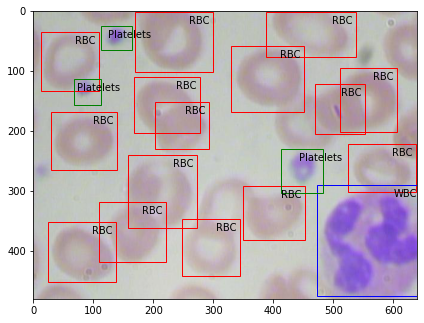

In [ ]:
#@title SAMPLE PLOT - shape (480, 640, 3)
fig = plt.figure()
import cv2
#add axes to the image
ax = fig.add_axes([0,0,1,1])

# read and plot the image
image = plt.imread('/content/BCCD_Dataset/BCCD/JPEGImages/BloodImage_00407.jpg')
plt.imshow(image)

# iterating over the image for different objects
for _,row in df_test[df_test.filename == "71.jpg"].iterrows():
    xmin = row.xmin
    xmax = row.xmax
    ymin = row.ymin
    ymax = row.ymax
    
    width = xmax - xmin
    height = ymax - ymin
    
    # assign different color to different classes of objects
    if row.cell_type == 'RBC':
        edgecolor = 'r'
        ax.annotate('RBC', xy=(xmax-40,ymin+20))
    elif row.cell_type == 'WBC':
        edgecolor = 'b'
        ax.annotate('WBC', xy=(xmax-40,ymin+20))
    elif row.cell_type == 'Platelets':
        edgecolor = 'g'
        ax.annotate('Platelets', xy=(xmax-40,ymin+20))
        
    # add bounding boxes to the image
    rect = patches.Rectangle((xmin,ymin), width, height, edgecolor = edgecolor, facecolor = 'none')
    
    ax.add_patch(rect)

# Splitting into training and validation datasets

In [ ]:
# print(df.shape)
# df_train, df_test = model_selection.train_test_split(df, test_size=0.1, random_state=13, shuffle=True)
print(df_train.shape, df_val.shape, df_test.shape)

(2805, 16) (1138, 16) (945, 16)


In [ ]:
os.mkdir('/content/bcc/')
os.mkdir('/content/bcc/images/')
os.mkdir('/content/bcc/images/train/')
os.mkdir('/content/bcc/images/val/')
os.mkdir('/content/bcc/images/test/')

os.mkdir('/content/bcc/labels/')
os.mkdir('/content/bcc/labels/train/')
os.mkdir('/content/bcc/labels/val/')
os.mkdir('/content/bcc/labels/test/')

# Data segregation and moving to it's corresponding folders
- BCC
  - Images
    - Train (205 images [.jpg files])
    - Val (87 images [.jpg files])
    - Test (72 images [.jpg files])
  - Labels
    - Train (205 labels [.txt files])
    - Val (87 labels [.txt files])
    - Test (72 labels [.txt files])


In [ ]:
def segregate_data(df, img_path, label_path, train_img_path, train_label_path):
  filenames = []
  for filename in df.filename:
    filenames.append(filename)
  filenames = set(filenames)
  
  for filename in filenames:
    yolo_list = []

    for _,row in df[df.filename == filename].iterrows():
      yolo_list.append([row.labels, row.x_center_norm, row.y_center_norm, row.width_norm, row.height_norm])

    yolo_list = np.array(yolo_list)
    txt_filename = os.path.join(train_label_path,str(row.prev_filename.split('.')[0])+".txt")
    # Save the .img & .txt files to the corresponding train and test folders
    np.savetxt(txt_filename, yolo_list, fmt=["%d", "%f", "%f", "%f", "%f"])
    shutil.copyfile(os.path.join(img_path,row.prev_filename), os.path.join(train_img_path,row.prev_filename))

In [ ]:
%%time
src_img_path = "/content/BCCD_Dataset/BCCD/JPEGImages/"
src_label_path = "/content/BCCD_Dataset/BCCD/Annotations/"

train_img_path = "/content/bcc/images/train"
train_label_path = "/content/bcc/labels/train"

val_img_path = "/content/bcc/images/val"
val_label_path = "/content/bcc/labels/val"

test_img_path = "/content/bcc/images/test"
test_label_path = "/content/bcc/labels/test"

segregate_data(df_train, src_img_path, src_label_path, train_img_path, train_label_path)
segregate_data(df_val, src_img_path, src_label_path, val_img_path, val_label_path)
segregate_data(df_test, src_img_path, src_label_path, test_img_path, test_label_path)

CPU times: user 991 ms, sys: 105 ms, total: 1.1 s
Wall time: 1.1 s


In [ ]:
print("No. of Training images", len(os.listdir('/content/bcc/images/train')))
print("No. of Training labels", len(os.listdir('/content/bcc/labels/train')))

print("No. of Validation images", len(os.listdir('/content/bcc/images/val')))
print("No. of Validation labels", len(os.listdir('/content/bcc/labels/val')))

print("No. of Test images", len(os.listdir('/content/bcc/images/test')))
print("No. of Test labels", len(os.listdir('/content/bcc/labels/test')))

No. of Training images 205
No. of Training labels 205
No. of Validation images 87
No. of Validation labels 87
No. of Test images 72
No. of Test labels 72


# **END OF DATA PRE-PROCESSING**

#**YOLO V5 STARTS**

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

!cp -r '/content/yolov5/runs/train/BCCM2' '/content/drive/MyDrive/MLProject/YOLO100'
!cp -r '/content/inference/output2' '/content/drive/MyDrive/MLProject/YOLO100/output'

#!mkdir -p '/content/drive/MyDrive/MLProject/YOLO/'
#!cp -r '/content/bcc' '/content/drive/MyDrive/MLProject/YOLO/'

Mounted at /content/drive


# Cloning from the yolo v5 repo.
More can be found at here : [yolo](https://github.com/ultralytics/yolov5)

In [ ]:
!git clone  'https://github.com/ultralytics/yolov5.git'

Cloning into 'yolov5'...
remote: Enumerating objects: 10923, done.
remote: Total 10923 (delta 0), reused 0 (delta 0), pack-reused 10923
Receiving objects: 100% (10923/10923), 11.01 MiB | 17.96 MiB/s, done.
Resolving deltas: 100% (7549/7549), done.


In [ ]:
!pip install -qr '/content/yolov5/requirements.txt'  # install dependencies

     |████████████████████████████████| 596 kB 12.6 MB/s 


# WE SHOULD CREATE A .yaml FILE AND THEN PLACE IT INSIDE THE yolov5 FOLDER

#**Contents of YAML file**

train: /content/bcc/images/train                    
val: /content/bcc/images/val

nc: 3

names: ['Platelets', 'RBC', 'WBC']


In [ ]:
!echo -e 'train: /content/bcc/images/train\nval: /content/bcc/images/val\n\nnc: 3\nnames: ['Platelets', 'RBC', 'WBC']' >> bcc.yaml
!cat 'bcc.yaml'

train: /content/bcc/images/train
val: /content/bcc/images/val

nc: 3
names: [Platelets, RBC, WBC]


In [ ]:
shutil.copyfile('/content/bcc.yaml', '/content/yolov5/bcc.yaml')

'/content/yolov5/bcc.yaml'

#**Also edit the number of classes (nc) in the ./models/*.yaml file**

Choose the yolo model of your choice, here I chose yolov5s.yaml (yolo - small)


In [ ]:
!ls
!sed -i 's/nc: 80/nc: 3/g' ./yolov5/models/yolov5s.yaml

bcc	      blood_cell_detection_test.csv   sample_data
BCCD_Dataset  blood_cell_detection_train.csv  yolov5
bcc.yaml      blood_cell_detection_val.csv


<img src="https://cdn-images-1.medium.com/max/600/1*hCE5VwKkqHlZW466umYTTA.png">

# Training command

**Training Parameters**

!python 
- <'location of train.py file'> 
- --img <'width of image'>
- --batch <'batch size'>
- --epochs <'no of epochs'>
- --data <'location of the .yaml file'>
- --cfg <'Which yolo configuration you want'>(yolov5s/yolov5m/yolov5l/yolov5x).yaml | (small, medium, large, xlarge)
- --name <'Name of the best model after training'>

**METRICS FROM TRAINING PROCESS**

**No.of classes, No.of images, No.of targets, Precision (P), Recall (R), mean Average Precision (map)**
- Class | Images | Targets | P | R | mAP@.5 | mAP@.5:.95: |
- all   | 270    |     489 |    0.0899 |       0.827 |      0.0879 |      0.0551

In [ ]:
%%time

!python yolov5/train.py --img 640 --batch 8 --epochs 100 --data bcc.yaml --cfg yolov5/models/yolov5s.yaml --name BCCM

train: weights=yolov5/yolov5s.pt, cfg=yolov5/models/yolov5s.yaml, data=bcc.yaml, hyp=yolov5/data/hyps/hyp.scratch.yaml, epochs=100, batch_size=8, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=yolov5/runs/train, name=BCCM, exist_ok=False, quad=False, linear_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.0-273-g4de8b24 torch 1.10.0+cu111 CUDA:0 (Tesla K80, 11441MiB)

hyperparameters: lr0=0.01, lrf=0.1, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s=0.7, hsv_

# BATCH PREDICTION
- Results saved to inference/output


**Inference Parameters**

!python 
- <'location of detect.py file'> 
- --source <'location of image/ folder to predict'>
- --weight <'location of the saved best weights'>
- --name <'location of output files after prediction'>

In [ ]:
#!ls
!python yolov5/detect.py --source '/content/bcc/images/test/' --weights /content/yolov5/runs/train/BCCM2/weights/best.pt --name '/content/inference/output' | tee '/content/out.txt'

detect: weights=['/content/yolov5/runs/train/BCCM2/weights/best.pt'], source=/content/bcc/images/test/, data=yolov5/data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=yolov5/runs/detect, name=/content/inference/output, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.0-273-g4de8b24 torch 1.10.0+cu111 CUDA:0 (Tesla K80, 11441MiB)

Fusing layers... 
Model Summary: 213 layers, 7018216 parameters, 0 gradients, 15.8 GFLOPs
image 1/72 /content/bcc/images/test/BloodImage_00007.jpg: 480x640 1 Platelets, 11 RBCs, 1 WBC, Done. (0.030s)
image 2/72 /content/bcc/images/test/BloodImage_00011.jpg: 480x640 14 RBCs, 1 WBC, Done. (0.029s)
image 3/72 /content/bcc/images/test/BloodImage_00015.jpg: 480x640 2 Plateletss, 16 RBCs, 1 WBC, Done. (0.0

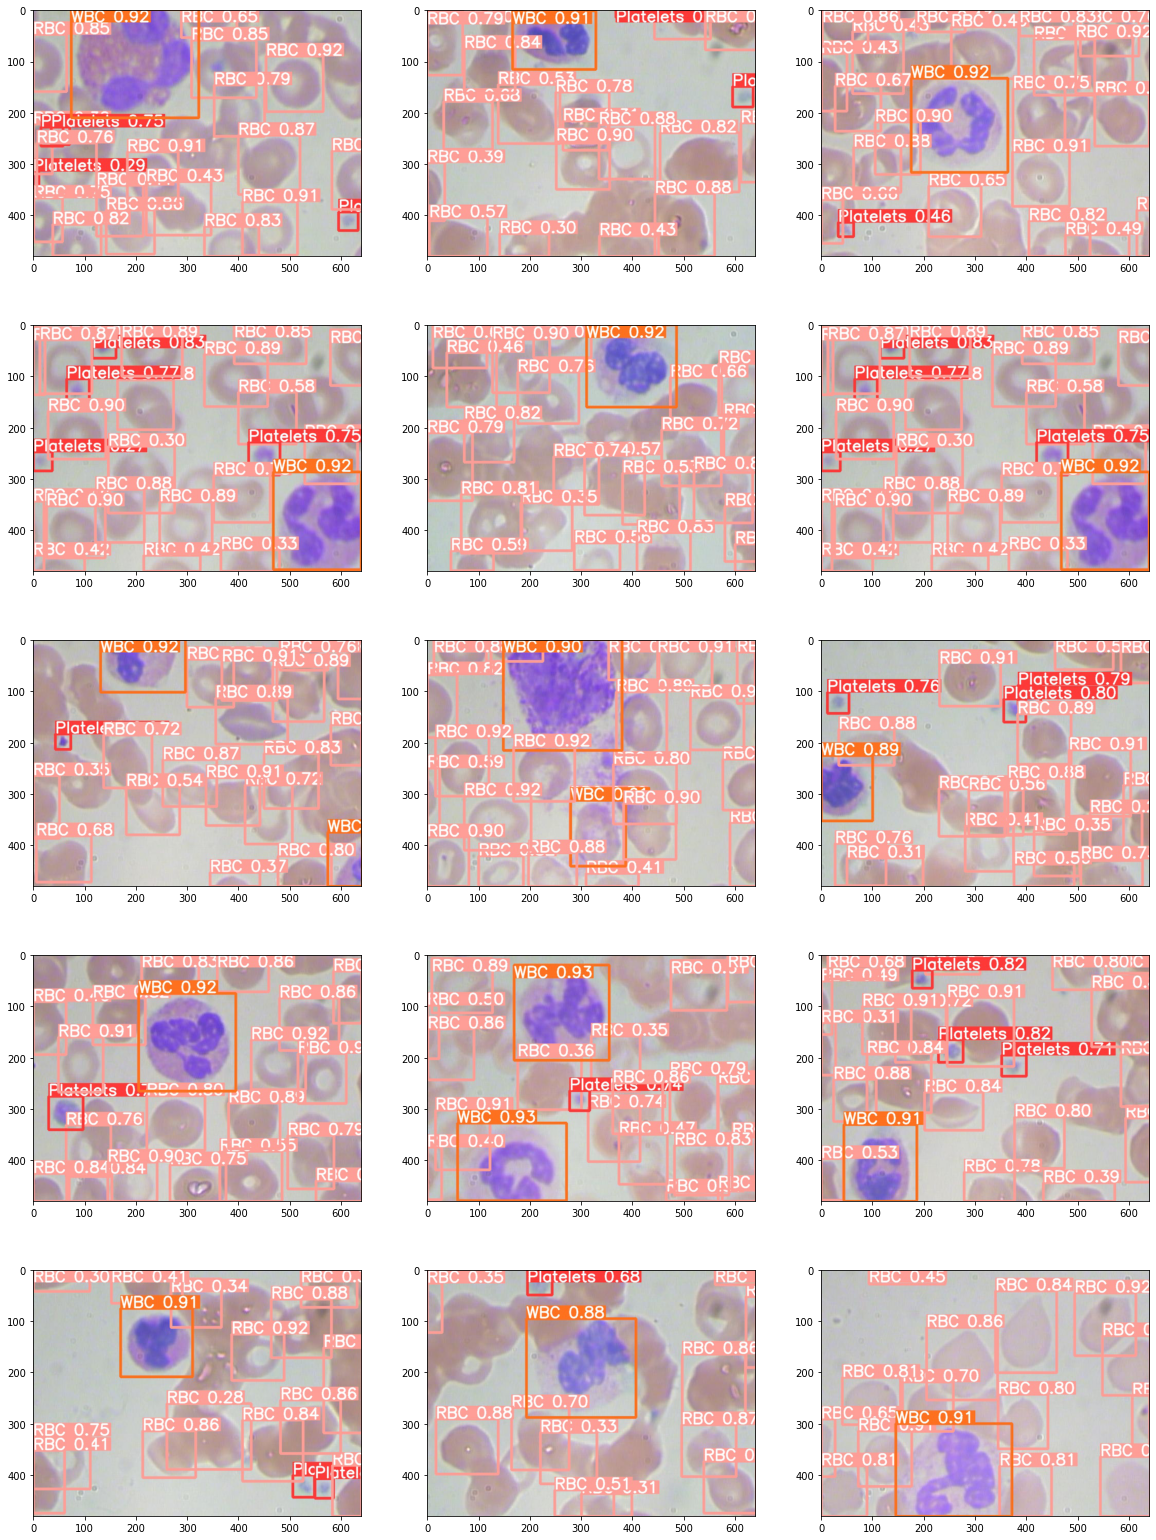

In [ ]:
disp_images = glob('/content/inference/output2/*')
fig=plt.figure(figsize=(20, 28))
columns = 3
rows = 5
for i in range(1, columns*rows +1):
    img = np.random.choice(disp_images)
    img = plt.imread(img)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

# SINGLE IMAGE PREDICTIONS


detect: weights=['/content/yolov5/runs/train/BCCM2/weights/best.pt'], source=/content/bcc/images/test/BloodImage_00407.jpg, data=yolov5/data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=yolov5/runs/detect, name=/content/inference/output2/single/, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.0-273-g4de8b24 torch 1.10.0+cu111 CUDA:0 (Tesla K80, 11441MiB)

Fusing layers... 
Model Summary: 213 layers, 7018216 parameters, 0 gradients, 15.8 GFLOPs
image 1/1 /content/bcc/images/test/BloodImage_00407.jpg: 480x640 4 Plateletss, 20 RBCs, 1 WBC, Done. (0.030s)
Speed: 0.6ms pre-process, 29.7ms inference, 2.4ms NMS per image at shape (1, 3, 640, 640)
Results saved to /content/inference/output2/single


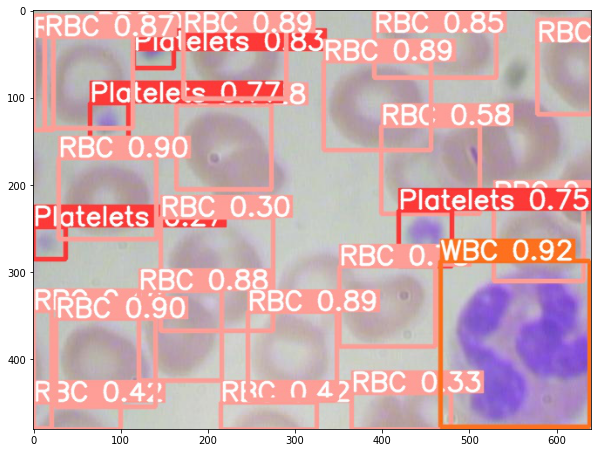

In [ ]:
# output = !python yolov5/detect.py --source /content/bcc/images/valid/BloodImage_00000.jpg --weights '/content/yolov5/runs/train/BCCM/weights/best.pt'
# print(output)

try:
  shutil.rmtree('/content/inference/output2/single/')
except FileNotFoundError:
  pass

!python yolov5/detect.py --source /content/bcc/images/test/BloodImage_00407.jpg --weights '/content/yolov5/runs/train/BCCM2/weights/best.pt' --name '/content/inference/output2/single/'

disp_images = glob('/content/inference/output2/single/*')
fig=plt.figure(figsize=(10, 18))
columns = 1
rows = 1
for i in range(1, columns*rows +1):
    img = np.random.choice(disp_images)
    img = plt.imread(img)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

# You need these files, if you wish to move the model to production

## Files

In [ ]:
!mkdir -p '/content/drive/MyDrive/MLProject/YOLO/SOURCE'
shutil.copyfile('/content/yolov5/detect.py', '/content/drive/MyDrive/MLProject/YOLO/SOURCE/detect.py')
shutil.copyfile('/content/yolov5/requirements.txt', '/content/drive/MyDrive/MLProject/YOLO/SOURCE/requirements.txt')
shutil.copyfile('/content/yolov5/runs/train/BCCM/weights/best.pt', '/content/drive/MyDrive/MLProject/YOLO/SOURCE/best_BCCM.pt')



'/content/drive/MyDrive/MLProject/YOLO/SOURCE/best_BCCM.pt'

## Folder

In [ ]:
!cp -r '/content/yolov5/models' '/content/drive/MyDrive/MLProject/YOLO/SOURCE/'
!cp -r '/content/yolov5/utils' '/content/drive/MyDrive/MLProject/YOLO/SOURCE/'


In [ ]:
import os
def input_split(folder):
	totalPlatelet = totalRBC = totalWBC = 0
	for filename in os.listdir(folder):
		with open(folder+'/'+filename, encoding='utf8') as f:
			for line in f:
				trimmedLine = line.strip()

				if int(trimmedLine[0]) == 0:
				    totalPlatelet += 1
				elif int(trimmedLine[0]) == 1:
				    totalRBC += 1
				elif int(trimmedLine[0]) == 2:
				    totalWBC += 1
	print(totalPlatelet, totalRBC, totalWBC)

folder = '/content/bcc/labels/test'
input_split(folder)

69 805 71


In [ ]:
totalPlatelet = totalRBC = totalWBC = 0

with open('/content/out.txt', encoding='utf8') as f:
    for line in f:
        trimmedLine = line.strip()

        indexPlatelet = trimmedLine.find('Platelet')
        indexRBC = trimmedLine.find('RBC')
        indexWBC = trimmedLine.find('WBC')

        if indexPlatelet != -1:
            countPlatelet = trimmedLine[indexPlatelet - 3: indexPlatelet].strip()
            totalPlatelet += int(countPlatelet)
            # print(countPlatelet, end=', ')
        if indexRBC != -1:
            countRBC = trimmedLine[indexRBC - 3: indexRBC].strip()
            totalRBC += int(countRBC)
            # print(countRBC, end=', ')
        if indexWBC != -1:
            countWBC = trimmedLine[indexWBC - 3: indexWBC].strip()
            totalWBC += int(countWBC)
            # print(countWBC, end='')

        # print()

print(totalPlatelet, totalRBC, totalWBC)

85 1268 79
